In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time
import json

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

data_folder = "data"
article_files = ["articles2019-06-01_" + str(i) + "-" + str(i + 5000) + ".csv" for i in range(0, 100000, 5000)]
article_files = article_files + ["articles2019-06-01_100000-100755.csv"]
article_df = [readArticles(os.path.join(data_folder, file)) for file in article_files]

article_df = pd.concat(article_df)
article_df = article_df.reset_index(drop = True)

# Get rid of garbage articles:
# < 500 chars - not articles, most likely videos or other media
# < 1000 chars and contains keyword, not full article, most likely paywall message of some sort 

keywords = ["subscription", "subscribe", "full access", "digital access", "sign up", "unlimited access", "unlimited digital access", "log in", "sign up"]

def keywordsin(str):
    for word in keywords:
        if word in str:
            return True
    return False

def isPaywall(text, to_doc = True):
    text = text.lower()
    if len(text) < 500:
        article_df.loc[i, "paywall"] += 0.5
    if len(text) < 1000 and keywordsin(text):
        article_df.loc[i, "paywall"] += 1
    if to_doc and article_df.loc[i, "doc"] is None:
        article_df.loc[i, "doc"] = docs.Document(text, clean = False)
    return article_df.loc[i, "paywall"] > 0

article_df["paywall"] = 0

# events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
event_path = os.path.join(data_folder, "eventDict2019-06-01.json")
with open(event_path, encoding = "utf8") as json_file:
    events = json.load(json_file)
print(events.keys())
article_df.head(3)

dict_keys(['singletons', 'incompleteFingerprints', 'algoGroups', 'events', 'wordDict', 'entityDict'])


,id,publisher,scrape_time,on_homepage,url,title,text,fingerprint,event,doc,paywall
0,0,beforeitsnews.com,2019-06-01T04:51:24-04:00,True,https://beforeitsnews.com/v3/christian-news/20...,"47:2-3, 8-",First Option - Responsorial Psalm: Psalms 47:2...,"{'wordCounts': {'2': 1, '713350': 1, '14736': ...",NaN,None,0
1,1,thehindu.com,2019-06-01T08:44:25-04:00,True,https://www.thehindu.com/news/cities/Coimbator...,"In Gudalur, meat will come packed in Koova lea...","ePaper \n Just In \n In Gudalur, meat will com...","{'wordCounts': {'80836': 1, '3': 314, '11': 15...",NaN,None,0
2,2,cincinnati.com,2019-06-01T15:30:59-04:00,False,https://www.cincinnati.com/story/money/cars/20...,Trump's Mexico tariffs would hurt GM the most ...,FacebookEmail Twitter Google+ LinkedIn Pintere...,"{'wordCounts': {'17655': 1, '1999': 1, '3693':...",1.0,None,0


In [2]:
N = len(article_df)
N_top50 = np.sum(1 - np.isnan(article_df["event"]))
print("Number of singletons: %d" % len(events['singletons']))
print("Number of articles clustered into top 50 events: %d/%d (.%d)" % (N_top50, N, round(N_top50/N, 2) * 100))

ac = tc.ArticleComparisons()

Number of singletons: 64173
Number of articles clustered into top 50 events: 33124/100756 (.33)


Mean, 5/25/50/75/95 percentiles: 2929.366 [ 119.9   796.75 1880.5  3979.5  8275.9 ]


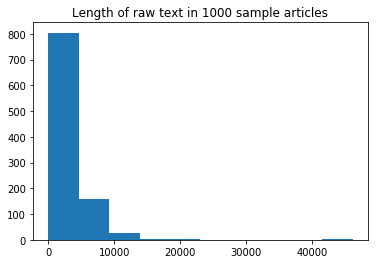

In [3]:
n = 1000
sample = random.sample(list(article_df["id"]), n)
article_dict = dict_by_ids(article_df, sample)
start = time.time()

text_len = [len(article_dict[id].text) for id in article_dict.keys()]
plt.hist(text_len)
plt.title("Length of raw text in %d sample articles" % n)
print("Mean, 5/25/50/75/95 percentiles:", np.mean(text_len), np.percentile(text_len, [5, 25, 50, 75, 95]))

In [4]:
start = time.time()
# for i in range(len(article_df)):
for i in sample:
    if (len(sample) > 1000 and i % 100 == 0):
        print(i, time.time() - start, "seconds elapsed")
    # Suspicious if article contains keywords
    isPaywall(article_df.loc[i, "text"])

In [5]:
article_dict_good = dict_by_ids(article_df, [i for i in sample if article_df.loc[i, "paywall"] == 0])
article_dict_bad = dict_by_ids(article_df, [i for i in sample if article_df.loc[i, "paywall"] > 0])
print("Sample 'bad' articles: ", [str(article_dict[i]) for i in random.sample(list(article_dict_bad), 10)])
len(article_dict_bad), len(article_dict_good)

Sample 'bad' articles:  ['If you previously used a social network to login to WRAL.com, click the “Forgot your password” link to reset your password. \n Email', 'Animal Care Services Division City Of San Antonio \n 4710 State Hwy 151 San Antonio, TX 78212 \n record last updated 06-28-2016 @ 03:36:52 \n The information on this page is obtained from data entered by each     individual animal shelter. Each shelter may or may not keep this     information accurate with varying frequency. On any given day, a     shelter may have fewer or more available pets than noted here.    \n Powered by Petfinder', 'Elyria police: Drunk driver injured running over a\xa0pole \n Posted 11:46 am, June 1, 2019, by Talia Naquin \n Share this: \n ELYRIA, Ohio – Elyria police say a drunk driver was injured in a one-car crash that ended with a car on top of a pole. \n It happened on Lorain Boulevard around 9 a.m. Saturday. \n The driver was transported to the hospital. \n Elyria police report charges are coming

(186, 814)

In [7]:
score_mat = ac.jac_score_mat(article_dict_bad)
axislabels = list(article_dict_bad.keys())
clusters = ac.get_article_clusters(article_dict_bad)
ac.prop_unique_clusters()
# 76/400 "bad" articles, .5s, 67.1% unique
# 189/1000 bad articles, 2.5s, 49.2% unique
# 186/1000 bad articles, 7.3s, 52.2% unique

0 / 186 done, 0.0 seconds elapsed
19 / 186 done, 1.09 seconds elapsed
56 / 186 done, 3.45 seconds elapsed
112 / 186 done, 6.38 seconds elapsed
149 / 186 done, 7.34 seconds elapsed


0.521505376344086

In [ ]:
score_mat = ac.jac_score_mat(article_dict_good)
axislabels = list(article_dict_good.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()
# 324/400 "good" articles, 8s, 79.0% unique
# 814/1000 good articles, 

0 / 814 done, 0.0 seconds elapsed


In [9]:
score_mat = ac.jac_score_mat(article_dict)
axislabels = list(article_dict.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()
# 400 randomly sampled articles, 10s, 63.8% unique 
# 1000 randomly sampled articles, 1.5h, 49.2% unique 

0 / 1000 done, 0.0 seconds elapsed
100 / 1000 done, 1576.56 seconds elapsed
200 / 1000 done, 3323.61 seconds elapsed
300 / 1000 done, 5112.67 seconds elapsed
400 / 1000 done, 5557.72 seconds elapsed
500 / 1000 done, 6011.49 seconds elapsed
600 / 1000 done, 6341.31 seconds elapsed
700 / 1000 done, 6612.19 seconds elapsed
800 / 1000 done, 6778.99 seconds elapsed
900 / 1000 done, 6917.35 seconds elapsed


0.49206349206349204

In [ ]:
sample = random.sample(list(article_df.loc[article"id"]), n)

In [10]:
score_mat = ac.jac_score_mat(article_dict, weighted = False)
axislabels = list(article_dict.keys())
clusters = ac.get_article_clusters()
ac.prop_unique_clusters()

print("%s seconds taken" % np.round(time.time() - start, 2))
# 86.5% unique for n = 800 random singleton articles, ~1 hr
# 85.3% unique for n = 1000 random singleton articles, ~1.5 hrs

TypeError: jac_score_mat() got an unexpected keyword argument 'weighted'

In [ ]:
results = pd.read_csv(os.path.join("results", "results_20190531_clusters.csv"))
plt.scatter(results.loc[:, "n"], results.loc[:, "unique25"])
plt.title("Unique articles in clusters on 5/31/19, with maximum similarity of .25")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles, weighted by cluster size (thresh = 0.25): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique25"])/np.sum(results.loc[:, "n"]))
plt.figure()
plt.scatter(results.loc[:, "n"], results.loc[:, "unique75"])
plt.title("Unique articles in clusters on 5/31/19, with maximum similarity of .75")
plt.xlabel("# articles in cluster")
plt.ylabel("% of unique articles")
print("Average % unique articles, weighted by cluster size (thresh = 0.75): ", np.sum(results.loc[:, "n"] * results.loc[:, "unique75"])/np.sum(results.loc[:, "n"]))